Outputs `transcripts.parquet` as intermediate data.

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import tifffile
from matplotlib import pyplot as plt

In [2]:
# File paths
dataset = "MERSCOPE_WT_1"
data_path = f"../data/{dataset}/"
output_path = f"../output/{dataset}/"

# Transformation parameters
pixel_size = 0.10799861
x_shift = int(-266.1734)
y_shift = int(180.2510)

In [ ]:
def adaptive_thresholding_with_size_filter_and_dilation(img, block_size=49, c=-1, min_area=100, radius=10):
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    filtered_img = np.zeros_like(th)
    cv2.drawContours(filtered_img, filtered_contours, -1, 255, -1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    th_dilated = cv2.dilate(filtered_img, kernel)
    return th_dilated

In [4]:
# Mapping
cells = pd.read_csv(data_path +"raw_data/metadata.csv")
cells = cells[cells["transcript_count"] > 0].copy()
cells = cells[["EntityID", "center_x", "center_y"]].copy()
cells.columns = ["cell_id", "x", "y"]

cells["row"] = (cells["y"] / pixel_size).astype(int) + y_shift
cells["col"] = (cells["x"] / pixel_size).astype(int) + x_shift

img = tifffile.imread(data_path + "raw_data/DAPI_images/mosaic_DAPI_z0.tif")
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

step = 10
for i in range(len(cells)):
    row = int(cells.iloc[i]["row"])
    col = int(cells.iloc[i]["col"])
    img_bgr[row - step: row + step, col - step: col + step] = [0, 0, 255]

img_bgr_small = cv2.resize(img_bgr, (3500, 5000), interpolation = cv2.INTER_AREA)
cv2.imwrite(data_path + "intermediate_data/images/mapping.png", img_bgr_small)

True

In [5]:
# All DAPI images
files = os.listdir(data_path + "raw_data/DAPI_images/")
files = [i for i in files if i.startswith("mosaic_DAPI_z")]
files.sort()
files

['mosaic_DAPI_z0.tif',
 'mosaic_DAPI_z1.tif',
 'mosaic_DAPI_z2.tif',
 'mosaic_DAPI_z3.tif',
 'mosaic_DAPI_z4.tif',
 'mosaic_DAPI_z5.tif',
 'mosaic_DAPI_z6.tif']

In [6]:
# Read transcripts
transcripts = pd.read_csv(data_path + "raw_data/transcripts.csv")
transcripts = transcripts[["cell_id", "gene", "global_x", "global_y", "global_z"]].copy()
transcripts.head()

,cell_id,gene,global_x,global_y,global_z
0,-1,Inpp4b,133.08844,2717.2595,0.0
1,-1,Inpp4b,187.72237,2653.8596,1.0
2,4388284201180100135,Inpp4b,69.97584,2656.0925,1.0
3,-1,Inpp4b,170.35840,2744.3406,1.0
4,-1,Gfap,90.94957,2735.0588,2.0


In [7]:
# Main operations on transcripts

# Compute DAPI pixel coordinates
transcripts["row"] = (transcripts["global_y"] / pixel_size).astype(int) + y_shift
transcripts["col"] = (transcripts["global_x"] / pixel_size).astype(int) + x_shift

# Add default overlap column
transcripts["overlaps_nucleus_5_dilation"] = 0
transcripts["overlaps_nucleus_10_dilation"] = 0

# Update labels in place
global_ratio = []

for i, radius in enumerate([5, 10]):
    
    print(f"Processing dilation radius: {radius}")

    for j, fname in enumerate(files):
        
        # Load DAPI image
        img = tifffile.imread(data_path + f"raw_data/DAPI_images/{fname}")
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Threshold and dilate
        th = adaptive_thresholding_with_size_filter_and_dilation(img, block_size=49, c=-1, min_area=100, radius=radius)

        # Save resized visualization (optional)
        th_small = cv2.resize(th, (3500, 5000), interpolation=cv2.INTER_AREA)
        cv2.imwrite(f"intermediate_data/images/z_{j}_small.png", th_small)
        
        # Select transcripts in this z-layer
        trans_z_mask = transcripts["global_z"] == j
        trans_z = transcripts[trans_z_mask].copy()
        row_vals = trans_z["row"].astype(int).values
        col_vals = trans_z["col"].astype(int).values

        # Avoid out-of-bounds indexing
        height, width = th.shape
        valid = (row_vals >= 0) & (row_vals < height) & (col_vals >= 0) & (col_vals < width)
        row_valid = row_vals[valid]
        col_valid = col_vals[valid]
        
        # Assign in-nucleus labels
        overlaps = np.zeros(len(trans_z), dtype=int)
        overlaps[valid] = (th[row_valid, col_valid] != 0).astype(int)

        # Update main DataFrame in-place
        transcripts.loc[trans_z.index, f"overlaps_nucleus_{radius}_dilation"] = overlaps

        # Track global ratio
        global_ratio.append(overlaps.mean())
        print(f"Iteration {j+1}: {np.sum(row_vals != row_valid)} row mismatches, {np.sum(col_vals != col_valid)} column mismatches, {overlaps.mean():.2%} in-nucleus")

Processing dilation radius: 5
Iteration 1: 0 row mismatches, 0 column mismatches, 25.68% in-nucleus
Iteration 2: 0 row mismatches, 0 column mismatches, 26.89% in-nucleus
Iteration 3: 0 row mismatches, 0 column mismatches, 28.21% in-nucleus
Iteration 4: 0 row mismatches, 0 column mismatches, 29.05% in-nucleus
Iteration 5: 0 row mismatches, 0 column mismatches, 29.46% in-nucleus
Iteration 6: 0 row mismatches, 0 column mismatches, 29.63% in-nucleus
Iteration 7: 0 row mismatches, 0 column mismatches, 29.72% in-nucleus
Processing dilation radius: 10
Iteration 1: 0 row mismatches, 0 column mismatches, 34.43% in-nucleus
Iteration 2: 0 row mismatches, 0 column mismatches, 35.86% in-nucleus
Iteration 3: 0 row mismatches, 0 column mismatches, 37.26% in-nucleus
Iteration 4: 0 row mismatches, 0 column mismatches, 38.10% in-nucleus
Iteration 5: 0 row mismatches, 0 column mismatches, 38.47% in-nucleus
Iteration 6: 0 row mismatches, 0 column mismatches, 38.47% in-nucleus
Iteration 7: 0 row mismatches

In [8]:
# Final labeled transcripts
transcripts = transcripts[["cell_id", "overlaps_nucleus_5_dilation", "overlaps_nucleus_10_dilation", "gene", "global_x", "global_y", "global_z"]].copy()
transcripts["global_z"] *= 1.5
transcripts = transcripts.rename(columns = {"gene": "target"})
transcripts.to_parquet(data_path + "intermediate_data/transcripts.parquet")
transcripts.head()

,cell_id,overlaps_nucleus_5_dilation,overlaps_nucleus_10_dilation,target,global_x,global_y,global_z
0,-1,0,0,Inpp4b,133.08844,2717.2595,0.0
1,-1,0,0,Inpp4b,187.72237,2653.8596,1.5
2,4388284201180100135,0,0,Inpp4b,69.97584,2656.0925,1.5
3,-1,0,0,Inpp4b,170.35840,2744.3406,1.5
4,-1,0,0,Gfap,90.94957,2735.0588,3.0


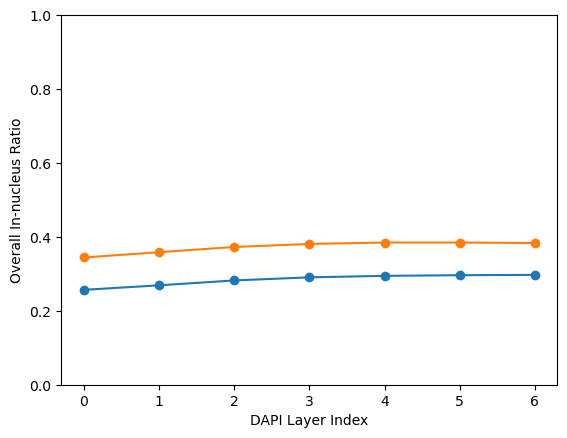

In [11]:
# Plot the global ratio
plot_x = list(range(len(files)))
# plot_y = global_ratio
plt.ylim([0, 1])
plt.plot(plot_x, global_ratio[:7], "o-")
plt.plot(plot_x, global_ratio[7:], "o-")
# plt.axhline(y = np.mean(plot_y), color = "r", linestyle = "dashed", linewidth = 0.8)
plt.xlabel("DAPI Layer Index")
plt.ylabel("Overall In-nucleus Ratio")
plt.show()

In [13]:
# transcripts = pd.read_parquet("intermediate_data/transcripts.parquet")
print(f"Average in-nucleus ratio (5 dilation): {transcripts['overlaps_nucleus_5_dilation'].mean()}")
print(f"Average in-nucleus ratio (10 dilation): {transcripts['overlaps_nucleus_10_dilation'].mean()}")

Average in-nucleus ratio (5 dilation): 0.2837372197102156
Average in-nucleus ratio (10 dilation): 0.3727629957996842


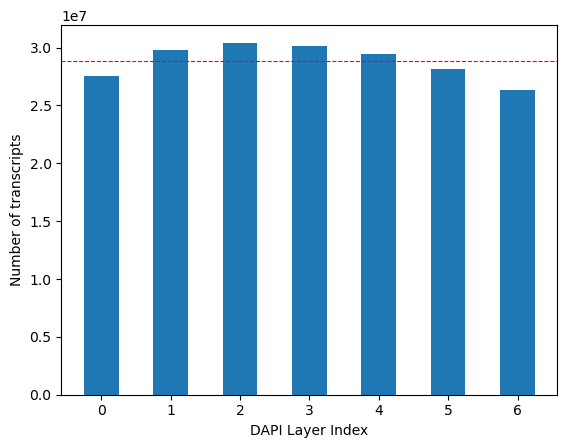

In [14]:
plot_x = range(len(transcripts["global_z"].unique()))
plot_y = transcripts.groupby(["global_z"]).size().tolist()
plt.bar(plot_x, plot_y, width = 0.5)
plt.axhline(y = np.mean(plot_y), color = "r", linestyle = "dashed", linewidth = 0.8)
plt.xlabel("DAPI Layer Index")
plt.ylabel("Number of transcripts")
plt.show()